### Prerequsite - Upgrade Scikit Learn
The current workspace has scikit-learn v0.19.1 installed. However, you can upgrade scikit-learn to 0.24.x. and use this [OneHotEncoder](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.OneHotEncoder.html) library. 


In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.2.


In [2]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

In [3]:
!python -m pip install --upgrade scikit-learn
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.6/site-packages (0.24.2)
The scikit-learn version is 0.24.2.


In [4]:
# Now you can import and use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
# your code goes here

In [5]:
# Similarly, should you need any other package, they can install it as:
!python -m pip install 'tensorflow-tensorboard<0.2.0,>=0.1.0'

    100% |████████████████████████████████| 1.6MB 6.6MB/s ta 0:00:011


# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [6]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
pd.options.display.max_rows = 300
pd.options.display.max_columns = 85

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [7]:
# Load in the general demographics data.
population = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';' )
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';' )


In [8]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
population.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [9]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [10]:
population.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [11]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [12]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,SEMIO_ERL,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [13]:
# Identify missing or unknown data values and convert them to NaNs.
for index, item in feat_info.iterrows():
    itemName = item['attribute']
   # print(population[itemName])
    item_value_miss_unknow = item['missing_or_unknown']
    missList = item_value_miss_unknow[1:-1].split(',')
    missRemoveList = [ int(x) if (x.isdigit() or (len(x) > 1 and x[0] == '-' and x[1:].isdigit())) else x for x in missList]
    if missRemoveList != ['']:
        population[itemName] = population[itemName].replace(missRemoveList, np.nan)
    
    


In [14]:
population.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
number_missing_data_all = population.isna().sum().sum()
number_missing_data_all

8373929

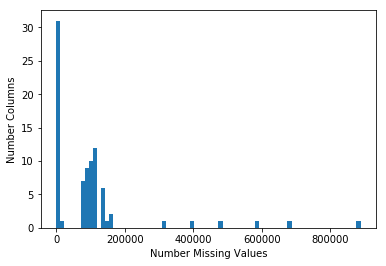

In [16]:
# Investigate patterns in the amount of missing data in each column.
num_missing_data = population.isna().sum().sort_values(ascending=False)
num_missing_data
plt.hist(num_missing_data, bins=75)
plt.ylabel('Number Columns')
plt.xlabel('Number Missing Values')
plt.show()


In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
colum_remove = num_missing_data[num_missing_data>200000]
colum_remove

TITEL_KZ        889061
AGER_TYP        685843
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
GEBURTSJAHR     392318
ALTER_HH        310267
dtype: int64

In [18]:
population.drop(colum_remove.index, axis=1,inplace=True)

In [19]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

In [20]:
population.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

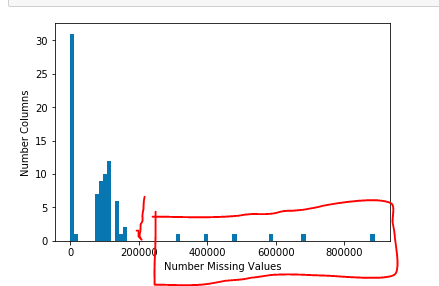
Base on image, we saw some column have number larger missing on the rigth image.

I will reomve it with condition num_missing_data>200000:
- TITEL_KZ        889061
- AGER_TYP        685843
- KK_KUNDENTYP    584612
- KBA05_BAUMAX    476524
- GEBURTSJAHR     392318
- ALTER_HH        310267

I choose 200000 because it makes sense to eliminate features with a large missing density. We can still reduce that number a little but still make sure

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [21]:
# How much data is missing in each row of the dataset?
number_missing_data_row_all = population.isna().sum(axis=1).sum()
number_missing_data_row_all


5035304

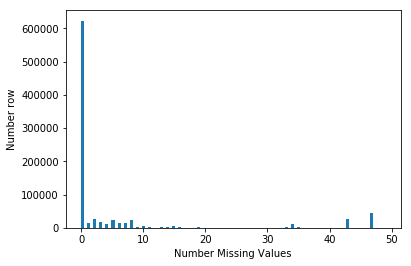

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
num_missing_data_row = population.isnull().sum(axis=1)
num_missing_data_row
plt.hist(num_missing_data_row, bins=100)
plt.ylabel('Number row')
plt.xlabel('Number Missing Values')
plt.show()


In [23]:
subset_missing_lt_20 = population[num_missing_data_row < 20]
subset_missing_gt_20 = population[num_missing_data_row >= 20]


In [24]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
less_missing = list(population.isna().sum().sort_values().index[:5])
less_missing

['ZABEOTYP', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST']

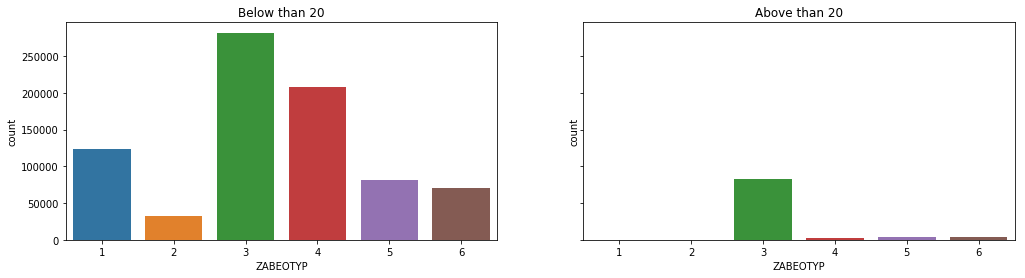

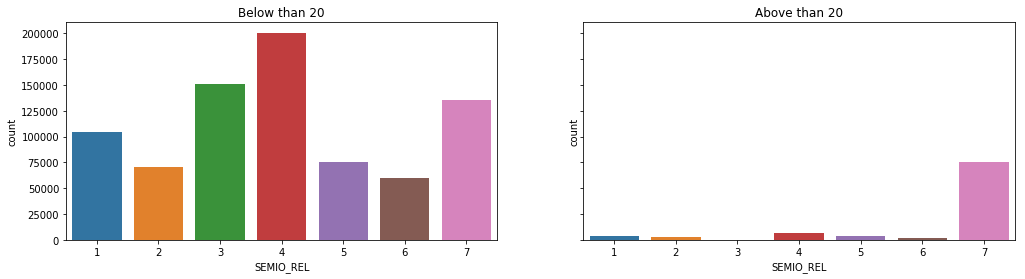

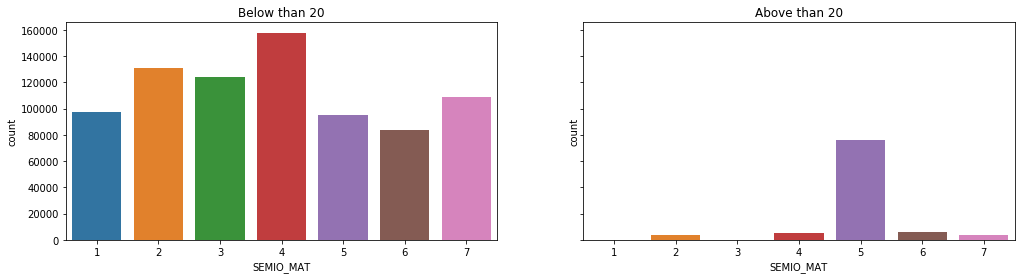

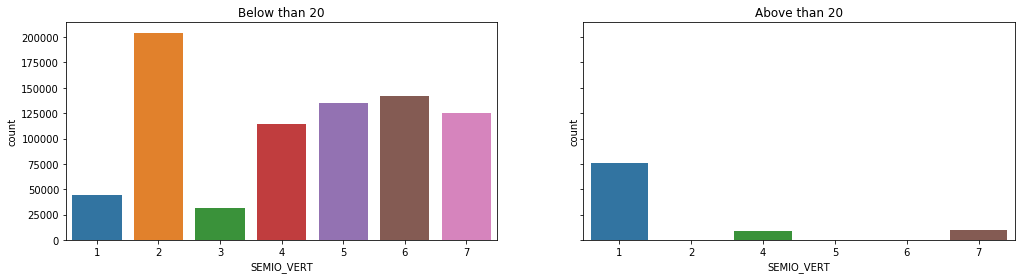

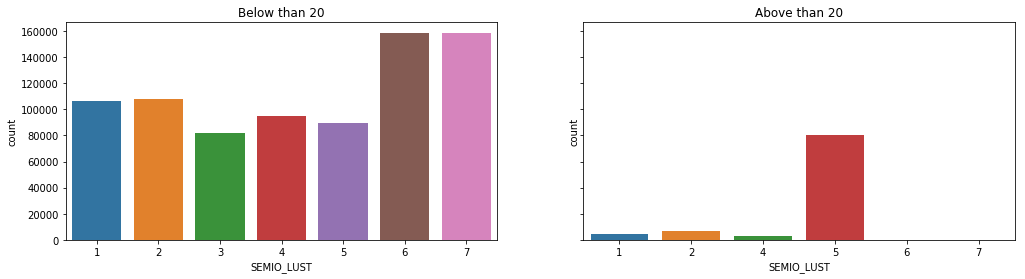

In [25]:
for col in less_missing:
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(17,4))
    ax1.set_title('Below than 20')
    sns.countplot(subset_missing_lt_20.loc[:,col] , ax=ax1)
    
    ax2.set_title('Above than 20')
    sns.countplot(subset_missing_gt_20.loc[:,col] , ax=ax2)



#### Discussion 1.1.3: Assess Missing Data in Each Row



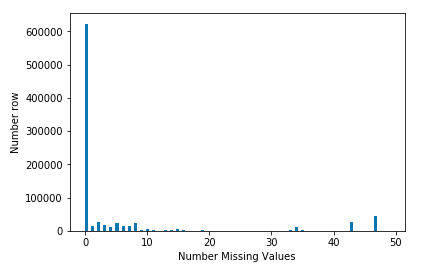

Base on image, I saw have more record that number feature missing large.

So I think it won't have much impact on the model, so it can be deleted. 
Based on the image, it is easy to see that the deletion threshold will be 20.

From the charts above, the distributions of values between the two datasets have more different => the data with lots of missing values are qualitatively different from data with few or no missing values.





### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [26]:
feat_info.groupby(['type']).size()


type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
dtype: int64

In [27]:
colum_remove

TITEL_KZ        889061
AGER_TYP        685843
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
GEBURTSJAHR     392318
ALTER_HH        310267
dtype: int64

In [28]:
feat_info_remove =feat_info[~feat_info['attribute'].isin(colum_remove.index)]

In [29]:
# How many features are there of each data type?
feat_info_remove.groupby(['type']).size()

type
categorical    18
mixed           6
numeric         6
ordinal        49
dtype: int64

In [30]:
feat_info_remove

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
10,FINANZTYP,person,categorical,[-1]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [31]:
categorical = feat_info_remove[feat_info_remove.type == 'categorical']
categorical

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [32]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
binary_feat = []
multi_level_feat = []
non_numeric = []
drop_multi_level_column = []
threshold = 5
print("-----------------------------------------")
for index, item in categorical.iterrows():
    column = item['attribute']
    number_value = subset_missing_lt_20[column].nunique()
    if number_value == 2:
        if subset_missing_lt_20[column].unique().dtype in ['int64','float64']:
            binary_feat.append(column)
        else:
            non_numeric.append(column)
    elif number_value > 2:
        if number_value > threshold:
            drop_multi_level_column.append(column)
        multi_level_feat.append(column) 
    
    print(" Column " + column + "    : " + str(number_value))

print("-----------------------------------------")
print('binary_feat : ',binary_feat)
print('non_numeric : ',non_numeric)
print('multi_level_feat : ',multi_level_feat)

-----------------------------------------
 Column ANREDE_KZ    : 2
 Column CJT_GESAMTTYP    : 6
 Column FINANZTYP    : 6
 Column GFK_URLAUBERTYP    : 12
 Column GREEN_AVANTGARDE    : 2
 Column LP_FAMILIE_FEIN    : 11
 Column LP_FAMILIE_GROB    : 5
 Column LP_STATUS_FEIN    : 10
 Column LP_STATUS_GROB    : 5
 Column NATIONALITAET_KZ    : 3
 Column SHOPPER_TYP    : 4
 Column SOHO_KZ    : 2
 Column VERS_TYP    : 2
 Column ZABEOTYP    : 6
 Column GEBAEUDETYP    : 7
 Column OST_WEST_KZ    : 2
 Column CAMEO_DEUG_2015    : 9
 Column CAMEO_DEU_2015    : 44
-----------------------------------------
binary_feat :  ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
non_numeric :  ['OST_WEST_KZ']
multi_level_feat :  ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [33]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Drop column
drop_multi_level_column

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_STATUS_FEIN',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [34]:
multi_level_feat = [feat for feat in multi_level_feat if feat not in drop_multi_level_column]
multi_level_feat

['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP']

In [35]:
subset_missing_lt_20.drop(drop_multi_level_column,axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [36]:

# Re-encode
subset_missing_lt_20['OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [37]:
subset_missing_lt_20 = pd.get_dummies(data=subset_missing_lt_20, columns=multi_level_feat)

In [38]:
subset_missing_lt_20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Data columns (total 83 columns):
ALTERSKATEGORIE_GROB     794304 non-null float64
ANREDE_KZ                797077 non-null int64
FINANZ_MINIMALIST        797077 non-null int64
FINANZ_SPARER            797077 non-null int64
FINANZ_VORSORGER         797077 non-null int64
FINANZ_ANLEGER           797077 non-null int64
FINANZ_UNAUFFAELLIGER    797077 non-null int64
FINANZ_HAUSBAUER         797077 non-null int64
GREEN_AVANTGARDE         797077 non-null int64
HEALTH_TYP               760739 non-null float64
LP_LEBENSPHASE_FEIN      747590 non-null float64
LP_LEBENSPHASE_GROB      750398 non-null float64
PRAEGENDE_JUGENDJAHRE    768753 non-null float64
RETOURTYP_BK_S           792445 non-null float64
SEMIO_SOZ                797077 non-null int64
SEMIO_FAM                797077 non-null int64
SEMIO_REL                797077 non-null int64
SEMIO_MAT                797077 non-null int64
SEMIO_VERT               797077

#### Discussion 1.2.1: Re-Encode Categorical Features

**With feature have multi level:**

I will keep feature have less 5 value, for else I will drop it.

With feature have less 5 value, I using pd.get_dummies to convert categorical variable into dummy/indicator variables. So, have some feature will be add to df. After that, I will delete feature have less 5 value:

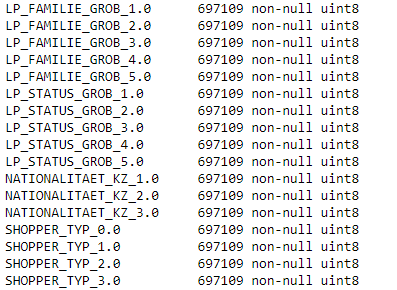

**With binary variable that takes on non-numeric values:**

I will covert to number value at feature OST_WEST_KZ that 'W' to 0 and  'O' to 1


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### Information get from Data_Dictionary.md
PRAEGENDE_JUGENDJAHRE

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [39]:
movement_mainstream = [1,3,5,8,10,12,14]
subset_missing_lt_20['movement'] = subset_missing_lt_20['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in movement_mainstream else 0)


In [40]:
def decade_norm(value):
    if value in [1,2]:
        return 1
    elif value in [3,4]:
        return 2
    elif value in [5,6,7]:
        return 3
    elif value in [8,9]:
        return 4
    elif value in [10,11,12,13]:
        return 5
    elif value in [14,15]:
        return 6
    else:
        return np.NaN
    
subset_missing_lt_20['decade'] = subset_missing_lt_20['PRAEGENDE_JUGENDJAHRE'].apply(decade_norm)


### Information get from Data_Dictionary.md
CAMEO_INTL_2015

German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [41]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
subset_missing_lt_20['wealth'] = subset_missing_lt_20['CAMEO_INTL_2015'].apply(lambda x: int(x[0]) if (len(str(x))==2 and x.isdigit()) else x)
subset_missing_lt_20['life_stage'] = subset_missing_lt_20['CAMEO_INTL_2015'].apply(lambda x: int(x[1]) if (len(str(x))==2 and x.isdigit()) else x)


In [42]:
subset_missing_lt_20['life_stage'].head()

1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
Name: life_stage, dtype: float64

In [43]:
subset_missing_lt_20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Data columns (total 87 columns):
ALTERSKATEGORIE_GROB     794304 non-null float64
ANREDE_KZ                797077 non-null int64
FINANZ_MINIMALIST        797077 non-null int64
FINANZ_SPARER            797077 non-null int64
FINANZ_VORSORGER         797077 non-null int64
FINANZ_ANLEGER           797077 non-null int64
FINANZ_UNAUFFAELLIGER    797077 non-null int64
FINANZ_HAUSBAUER         797077 non-null int64
GREEN_AVANTGARDE         797077 non-null int64
HEALTH_TYP               760739 non-null float64
LP_LEBENSPHASE_FEIN      747590 non-null float64
LP_LEBENSPHASE_GROB      750398 non-null float64
PRAEGENDE_JUGENDJAHRE    768753 non-null float64
RETOURTYP_BK_S           792445 non-null float64
SEMIO_SOZ                797077 non-null int64
SEMIO_FAM                797077 non-null int64
SEMIO_REL                797077 non-null int64
SEMIO_MAT                797077 non-null int64
SEMIO_VERT               797077

#### Discussion 1.2.2: Engineer Mixed-Type Features

We created:

Two column **movement, decade** to save value for **PRAEGENDE_JUGENDJAHRE**

Two column **wealth, life_stage** to save value for **CAMEO_INTL_2015**
    
=> All value in PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015 that split to save in new feature, so it is OK to delete 2 feature CAMEO_INTL_2015,PRAEGENDE_JUGENDJAHRE

**For other mixed :**

LP_LEBENSPHASE_FEIN(40 value ), LP_LEBENSPHASE_GROB(12 ), WOHNLAGE(8) , PLZ8_BAUMAX(5) .

I saw information hard to split to other feature + it have more value => So I will choose drop it

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [44]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
mixed_features_tmp = feat_info_remove[feat_info_remove['type'] == 'mixed']['attribute'].values
mixed_features_tmp

array(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015',
       'PLZ8_BAUMAX'], dtype=object)

In [45]:
subset_missing_lt_20.drop(mixed_features_tmp, axis=1, inplace=True)

In [46]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
subset_missing_lt_20.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,movement,decade,wealth,life_stage
1,1.0,2,1,5,2,5,4,5,0,3.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,6.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,6.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,4.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,4.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,2.0,5.0,4.0


In [47]:
subset_missing_lt_20.isnull().sum()

ALTERSKATEGORIE_GROB      2773
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
HEALTH_TYP               36338
RETOURTYP_BK_S            4632
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
SEMIO_KRIT                   0
SEMIO_DOM                    0
SEMIO_KAEM                   0
SEMIO_PFLICHT                0
SEMIO_TRADV                  0
SOHO_KZ                      0
VERS_TYP                 36338
ANZ_PERSONEN                 0
ANZ_TITEL                    0
HH_EINKOMMEN_SCORE           0
W_KEIT_KIND_HH           58715
WOHNDAUER_2008               0
ANZ_HAUS

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [48]:

def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    #clean_df = df.copy()
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for index, item in feat_info.iterrows():
        itemName = item['attribute']
        item_value_miss_unknow = item['missing_or_unknown']
        missList = item_value_miss_unknow[1:-1].split(',')
        missRemoveList = [ int(x) if (x.isdigit() or (len(x) > 1 and x[0] == '-' and x[1:].isdigit())) else x for x in missList]
        if missRemoveList != ['']:
            df[itemName] = df[itemName].replace(missRemoveList, np.nan)
    
    # remove selected columns and rows, ...
    df.drop(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH'], axis=1,inplace=True)
    feat_info_remove =feat_info[~feat_info['attribute'].isin(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH'])]

    # Keep < 5
    subset_missing_lt_20  = df[population.isna().sum(axis=1) < 20]
    # select, re-encode, and engineer column values.
    categorical = feat_info_remove[feat_info_remove.type == 'categorical']
    
    binary_feat = []
    multi_level_feat = []
    non_numeric = []
    drop_multi_level_column = []
    threshold = 5
    print("-----------------------------------------")
    for index, item in categorical.iterrows():
        column = item['attribute']
        number_value = subset_missing_lt_20[column].nunique()
        if number_value == 2:
            if subset_missing_lt_20[column].unique().dtype in ['int64','float64']:
                binary_feat.append(column)
            else:
                non_numeric.append(column)
        elif number_value > 2:
            if number_value > threshold:
                drop_multi_level_column.append(column)
            multi_level_feat.append(column) 
    multi_level_feat = [feat for feat in multi_level_feat if feat not in drop_multi_level_column]        
    
    subset_missing_lt_20.drop(drop_multi_level_column,axis=1, inplace=True)
    
    subset_missing_lt_20['OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True)
    
    drop_muil_feat = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015']
    
    subset_missing_lt_20 = pd.get_dummies(data=subset_missing_lt_20, columns=multi_level_feat)
    
    #Engineer Mixed-Type Features
    # Edit PRAEGENDE_JUGENDJAHRE feature
    movement_mainstream = [1,3,5,8,10,12,14]
    subset_missing_lt_20['movement'] = subset_missing_lt_20['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in movement_mainstream else 0)
    subset_missing_lt_20['decade'] = subset_missing_lt_20['PRAEGENDE_JUGENDJAHRE'].apply(decade_norm)
    
    # Edit CAMEO_INTL_2015 feature
    subset_missing_lt_20['wealth'] = subset_missing_lt_20['CAMEO_INTL_2015'].apply(lambda x: int(x[0]) if (len(str(x))==2 and x.isdigit()) else x)
    subset_missing_lt_20['life_stage'] = subset_missing_lt_20['CAMEO_INTL_2015'].apply(lambda x: int(x[1]) if (len(str(x))==2 and x.isdigit()) else x)
    
    # Drop mixed feature
    mixed_features_tmp = feat_info_remove[feat_info_remove['type'] == 'mixed']['attribute'].values
    subset_missing_lt_20.drop(mixed_features_tmp, axis=1, inplace=True)
    
    
    # Return the cleaned dataframe.
    return subset_missing_lt_20
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [49]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
df_imputed = pd.DataFrame(imputer.fit_transform(subset_missing_lt_20), columns=subset_missing_lt_20.columns)

In [50]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df_imputed.columns)


### Discussion 2.1: Apply Feature Scaling

Base on link https://scikit-learn.org/0.20/whats_new.html#id35 I using SimpleImputer to clean mising value:
(*SimpleImputer same way with Imputer, but I got error when try to import Imputer*)

   1/ np.nan is default.

   2/ I using **most_frequent** to replace missing by using the most frequent value along each column and it can be used with strings or numeric data.

I using StandardScaler instance to each feature will be scaled to mean 0 and standard deviation 1, 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [52]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
df_pca = pca.fit_transform(df_scaled)


explained_variance_ratio
[1.44897826e-01 1.09233506e-01 7.74859333e-02 4.76065891e-02
 3.36801731e-02 2.74331993e-02 2.57684023e-02 2.41222344e-02
 2.25781889e-02 2.10109704e-02 1.91604960e-02 1.89057887e-02
 1.71071424e-02 1.67414950e-02 1.64224221e-02 1.60515323e-02
 1.55438127e-02 1.47239183e-02 1.43932872e-02 1.41571741e-02
 1.33014057e-02 1.31836856e-02 1.28055872e-02 1.25497030e-02
 1.23453705e-02 1.22273474e-02 1.16804728e-02 1.11042780e-02
 1.03921431e-02 1.01635307e-02 9.83350714e-03 8.97777482e-03
 8.57496205e-03 8.40429826e-03 7.83772704e-03 7.28644686e-03
 6.37974887e-03 6.05027059e-03 5.79820643e-03 5.69734769e-03
 5.47346438e-03 5.15060004e-03 5.02802951e-03 4.90690975e-03
 4.78889746e-03 4.73370990e-03 4.55228544e-03 4.30700888e-03
 3.97614098e-03 3.87959978e-03 3.69619335e-03 3.52151134e-03
 3.40425460e-03 3.25142770e-03 3.13057692e-03 3.08232786e-03
 3.03810386e-03 2.83585657e-03 2.79381497e-03 2.61898857e-03
 2.54025641e-03 2.42643866e-03 2.42152503e-03 2.35482915e-03

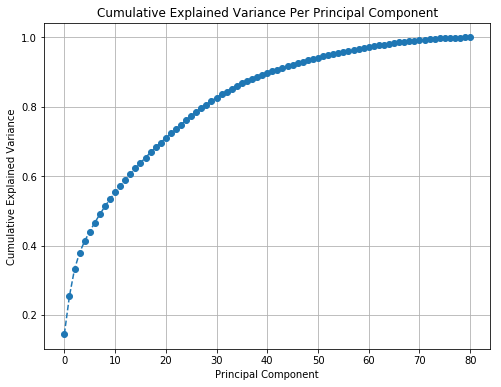

In [53]:
# Investigate the variance accounted for by each principal component.
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

print("explained_variance_ratio")
print(explained_variance_ratio)
print("cumulative_explained_variance")
print(cumulative_explained_variance)


plt.figure(figsize=(8, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance Per Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()



In [54]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"number of components to retain: {n_components}")

pca_final = PCA(n_components=n_components)
df_pca_final = pca_final.fit_transform(df_scaled)


number of components to retain: 54


### Discussion 2.2: Perform Dimensionality Reduction


I read page https://www.baeldung.com/cs/pca and saw note:

*A good strategy is to choose the number of dimensions for which the cumulative explained variance exceeds a threshold, e.g., 0.95 (95%).*

I decided to retain 54 principal components, it result of:
 **np.argmax(cumulative_explained_variance >= 0.95) + 1**

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [55]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def print_sorted_feature_weights(pca, component_number, feature_names):
    components = pca.components_
    feature_weights = components[component_number]
    feature_weight_pairs = list(zip(feature_names, feature_weights))
    sorted_feature_weight_pairs = sorted(feature_weight_pairs, key=lambda x: x[1], reverse=True)
    
    print(f"\n Feature_weights for{component_number + 1}:")
    for feature, weight in sorted_feature_weight_pairs:
        print(f"{feature}: {weight}")

# Gọi hàm để in ra trọng số đặc trưng cho ba thành phần chính đầu tiên
print_sorted_feature_weights(pca, 0, subset_missing_lt_20.columns)



 Feature_weights for1:
LP_STATUS_GROB_1.0: 0.21770633747349757
PLZ8_ANTG3: 0.21200320842168585
PLZ8_ANTG4: 0.20425004910301492
HH_EINKOMMEN_SCORE: 0.20013548656983474
wealth: 0.19639521838559434
ORTSGR_KLS9: 0.18476378570686589
EWDICHTE: 0.18288822782072348
FINANZ_HAUSBAUER: 0.1605227739855455
KBA05_ANTG4: 0.14736025517215162
PLZ8_ANTG2: 0.14500638607227065
FINANZ_SPARER: 0.14006205359606022
ARBEIT: 0.13337417341335567
KBA05_ANTG3: 0.13336820206783218
ANZ_HAUSHALTE_AKTIV: 0.13084846946756443
RELAT_AB: 0.1264296293748373
SEMIO_PFLICHT: 0.10869802338068942
SEMIO_REL: 0.10436033991200504
decade: 0.09878039603271968
movement: 0.09296861983765536
SEMIO_RAT: 0.09065025274838077
LP_FAMILIE_GROB_1.0: 0.08660224517655062
SEMIO_TRADV: 0.08184639545817643
SEMIO_MAT: 0.07257537612659688
FINANZ_UNAUFFAELLIGER: 0.07013790759126033
SEMIO_FAM: 0.06894585748127006
FINANZ_ANLEGER: 0.06809772669381958
SEMIO_KULT: 0.06279638400140147
NATIONALITAET_KZ_2.0: 0.059135150242977885
REGIOTYP: 0.0577730284224789

In [56]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_sorted_feature_weights(pca, 1, subset_missing_lt_20.columns)




 Feature_weights for2:
ALTERSKATEGORIE_GROB: 0.254534223187972
SEMIO_ERL: 0.23081905666346142
FINANZ_VORSORGER: 0.2258323057893315
SEMIO_LUST: 0.1782828786508585
RETOURTYP_BK_S: 0.15676401886231925
SEMIO_KRIT: 0.11933811547013348
W_KEIT_KIND_HH: 0.11733959222712073
SEMIO_KAEM: 0.11717380063961541
FINANZ_HAUSBAUER: 0.1138361223368844
ANREDE_KZ: 0.09619012045878694
SHOPPER_TYP_3.0: 0.09519618331999725
EWDICHTE: 0.08655112464612873
PLZ8_ANTG3: 0.0858964164898398
ORTSGR_KLS9: 0.08523989614332926
PLZ8_ANTG4: 0.08382573859042194
SEMIO_DOM: 0.07684494532521496
NATIONALITAET_KZ_1.0: 0.07148946456033246
wealth: 0.0681367029240062
KBA05_ANTG4: 0.06694713840223639
ARBEIT: 0.06342123617520931
FINANZ_MINIMALIST: 0.06323488113935771
RELAT_AB: 0.06085670507856096
PLZ8_ANTG2: 0.059422750095576383
ANZ_HAUSHALTE_AKTIV: 0.05899147598823055
LP_FAMILIE_GROB_1.0: 0.05702624592755771
WOHNDAUER_2008: 0.05625370865825071
HH_EINKOMMEN_SCORE: 0.052091967303411084
KBA05_ANTG3: 0.044083993346181106
LP_STATUS_GROB

In [57]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_sorted_feature_weights(pca, 2, subset_missing_lt_20.columns)




 Feature_weights for3:
SEMIO_VERT: 0.33288680077302596
SEMIO_SOZ: 0.2559013869816588
SEMIO_FAM: 0.24171410716908656
SEMIO_KULT: 0.22501108577400084
FINANZ_MINIMALIST: 0.14621179950591573
SHOPPER_TYP_0.0: 0.12555649872044988
RETOURTYP_BK_S: 0.10887107544626076
FINANZ_VORSORGER: 0.10151935194969786
W_KEIT_KIND_HH: 0.09562818866580064
ALTERSKATEGORIE_GROB: 0.07932031942574112
SEMIO_REL: 0.06527878593610341
SEMIO_LUST: 0.06449413361546576
ORTSGR_KLS9: 0.05521585233086561
PLZ8_ANTG4: 0.054649227167097775
EWDICHTE: 0.054087431520458015
PLZ8_ANTG3: 0.053834756431077525
SEMIO_MAT: 0.05057488903060204
SHOPPER_TYP_1.0: 0.04901671226261869
GREEN_AVANTGARDE: 0.04196141753358602
ARBEIT: 0.041215199879636275
RELAT_AB: 0.03766436672652364
PLZ8_ANTG2: 0.03609076621214925
wealth: 0.035790519913584944
KBA05_ANTG4: 0.03486033900558158
NATIONALITAET_KZ_1.0: 0.03299816722873839
ANZ_HAUSHALTE_AKTIV: 0.03120153992057969
WOHNDAUER_2008: 0.03043729979612854
LP_STATUS_GROB_5.0: 0.030196997648322843
LP_FAMILIE_

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

**First Principal Component**
- Positive weights

LP_STATUS_GROB_1.0: 0.21770633747349757 : low-income earners, it created from LP_STATUS_GROB (Social status), that we using get_dummies for multi-level categoricals feature .

PLZ8_ANTG3: 0.21200320842168585 : number of 6-10 family houses in the PLZ8 region

PLZ8_ANTG4: 0.20425004910301492 : Number of 10+ family houses in the PLZ8 region


- Negative weights

FINANZ_MINIMALIST: -0.21195210058243036 : Financial typology - low financial interest

KBA05_ANTG1: -0.21506225439545656 : Number of 1-2 family houses in the microcell

MOBI_REGIO: -0.21671692195150982 : Movement patterns

**2nd Principal Component**

- Positive weights

ALTERSKATEGORIE_GROB: 0.254534223187972 : Estimated age based on given name analysis

SEMIO_ERL: 0.23081905666346142 : Personality typology - event-oriented

FINANZ_VORSORGER: 0.2258323057893315 : Financial typology - be prepared

- Negative weights

FINANZ_SPARER: -0.23048321616464995 : Financial typology - money-saver

decade: -0.23602766767441002 : It from PRAEGENDE_JUGENDJAHRE(Dominating movement of person's youth) feature that contain decade information

SEMIO_REL: -0.2552094092400386: Personality typology - religious



**3rd Principal Component**
- Positive weights

SEMIO_VERT: 0.33288680077302596: Personality typology - dreamful

SEMIO_SOZ: 0.2559013869816588: Personality typology - socially-minded

SEMIO_FAM: 0.24171410716908656: Personality typology - family-minded

- Negative weights

SEMIO_DOM: -0.3061488572749065: Personality typology - dominant-minded

SEMIO_KAEM: -0.3258155983513427: Personality typology - combative attitude

ANREDE_KZ: -0.3563519337674231: Gender

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [61]:
from sklearn.cluster import KMeans
def caculator_score(data, n_cluster):
    # run k-means clustering 
    kmeans = KMeans(n_clusters = n_cluster)
    model = kmeans.fit(data)
    # compute the average within-cluster distances.
    score = np.abs(model.score(data))
    
    return score

In [62]:
lst_scores = []
centers = list(range(5, 25,2))
# Over a number of different cluster counts...
for center in centers:
    lst_scores.append(caculator_score(df_pca_final, center))
    print("Completed " + str(center))
    
    

Completed 5
Completed 7
Completed 9
Completed 11
Completed 13
Completed 15
Completed 17
Completed 19
Completed 21
Completed 23


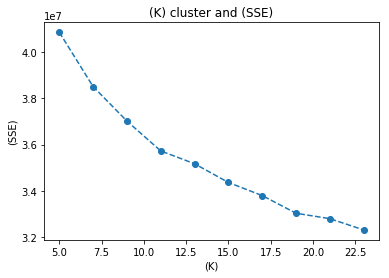

In [63]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, lst_scores, linestyle='--', marker='o');
plt.xlabel('(K)')
plt.ylabel('(SSE)')
plt.title("(K) cluster and (SSE)");


In [64]:
lst_scores

[40849944.68909877,
 38504225.01665167,
 37017254.42345709,
 35728795.778376795,
 35175374.56753533,
 34367945.271735154,
 33802653.68623615,
 33039414.482186366,
 32806173.54222757,
 32320477.3831064]

In [65]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmean_19 = KMeans(n_clusters = 19)
models_19 = kmean_19.fit(df_pca_final)
final_pred = models_19.predict(df_pca_final)


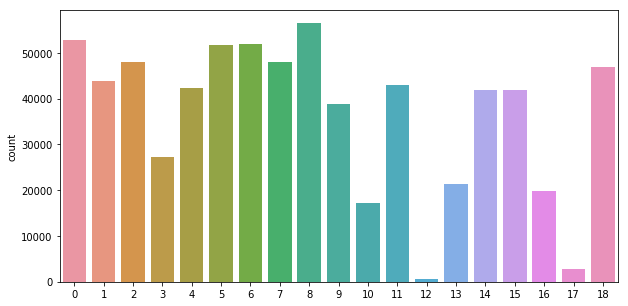

In [67]:
figure, axs = plt.subplots(nrows=1, ncols=1, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)


sns.countplot(final_pred)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

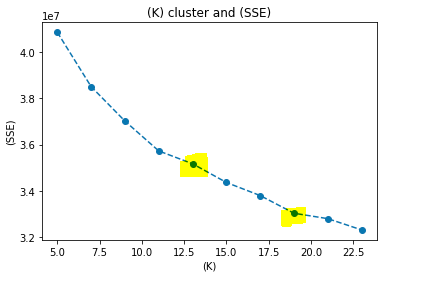

I have two choose that number cluster 13 or 19.
But I decide using 19 because I saw it is look like to make a Elbow Method


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [68]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';');

In [69]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_final = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


-----------------------------------------


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [70]:
number_customer_na = customers_final.isna().sum().sum()
number_customer_na

1719464

In [71]:
#cleaned the dataset of all NaN values
customers_final_imputed = pd.DataFrame(imputer.transform(customers_final), columns=customers_final.columns)

In [72]:
# Apply feature scaling to the general population demographics data.
customers_final_scaled = pd.DataFrame(scaler.transform(customers_final_imputed), columns=customers_final_imputed.columns)

In [73]:
# Apply PCA to the data.
customers_final_pca = pca_final.transform(customers_final_scaled)

customers_final_preds = models_19.predict(customers_final_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

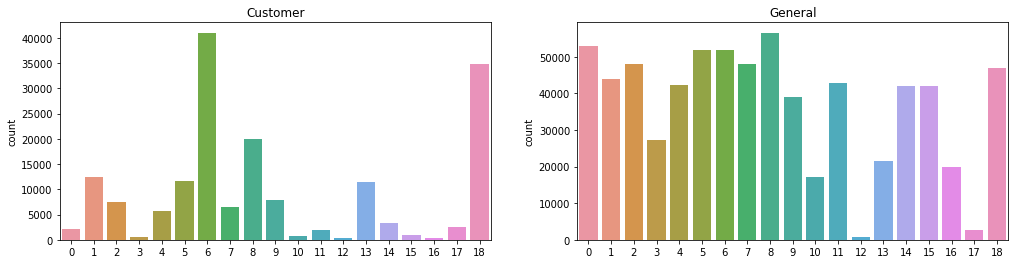

In [74]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(17,4))

ax1.set_title('Customer')
sns.countplot(customers_final_preds, ax=ax1)

ax2.set_title('General')
sns.countplot(final_pred, ax=ax2)



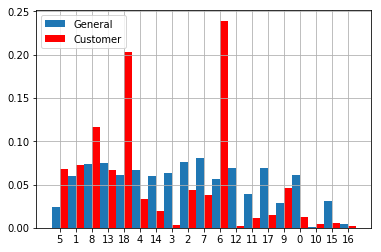

In [78]:
# https://knowledge.udacity.com/questions/905904
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
from collections import Counter
# generating proportion for the customer clusters.
labels, values = zip(*Counter(customers_final_preds).items())
v=list(values)
v[:] = [x/len(customers_final_preds) for x in v]
indexes = np.arange(len(labels))
# generating proportion for the azdias clusters.
labels1, values1 = zip(*Counter(final_pred).items())
v1=list(values1)
v1[:] = [x/len(final_pred) for x in v1]
indexes1 = np.arange(len(labels))
# configuring the graph
width = .5
plt.bar(indexes1, v1, width ,label='General')
plt.bar(indexes+width, v, width,  color='r' , label='Customer')
plt.xticks(indexes + width * 0.5, labels)
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [83]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_6 = scaler.inverse_transform(pca_final.inverse_transform(models_19.cluster_centers_[6]))



In [84]:
overrepresented = pd.Series(data = centroid_6, index=customers_final.columns)
overrepresented

ALTERSKATEGORIE_GROB        1.674052
ANREDE_KZ                   1.969979
FINANZ_MINIMALIST           2.317355
FINANZ_SPARER               3.927784
FINANZ_VORSORGER            2.196847
FINANZ_ANLEGER              4.364605
FINANZ_UNAUFFAELLIGER       3.913278
FINANZ_HAUSBAUER            2.878156
GREEN_AVANTGARDE            0.206539
HEALTH_TYP                  2.231066
RETOURTYP_BK_S              2.445342
SEMIO_SOZ                   2.630277
SEMIO_FAM                   3.654161
SEMIO_REL                   5.215246
SEMIO_MAT                   5.037772
SEMIO_VERT                  2.644249
SEMIO_LUST                  3.150022
SEMIO_ERL                   4.218466
SEMIO_KULT                  4.179563
SEMIO_RAT                   6.272493
SEMIO_KRIT                  5.385891
SEMIO_DOM                   5.940768
SEMIO_KAEM                  5.529519
SEMIO_PFLICHT               5.988271
SEMIO_TRADV                 6.066600
SOHO_KZ                     0.008958
VERS_TYP                    1.412203
A

In [85]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_3 = scaler.inverse_transform(pca_final.inverse_transform(models_19.cluster_centers_[3]))

In [86]:
underrepresented = pd.Series(data = centroid_3, index=customers_final.columns)
underrepresented

ALTERSKATEGORIE_GROB        2.368456
ANREDE_KZ                   1.003123
FINANZ_MINIMALIST           2.551823
FINANZ_SPARER               3.538986
FINANZ_VORSORGER            2.888171
FINANZ_ANLEGER              2.784504
FINANZ_UNAUFFAELLIGER       2.929409
FINANZ_HAUSBAUER            3.160633
GREEN_AVANTGARDE            0.085257
HEALTH_TYP                  2.615341
RETOURTYP_BK_S              3.529703
SEMIO_SOZ                   5.959814
SEMIO_FAM                   6.139876
SEMIO_REL                   5.324346
SEMIO_MAT                   4.870025
SEMIO_VERT                  5.724543
SEMIO_LUST                  3.400527
SEMIO_ERL                   3.095897
SEMIO_KULT                  6.197866
SEMIO_RAT                   3.547462
SEMIO_KRIT                  3.707520
SEMIO_DOM                   3.526999
SEMIO_KAEM                  2.809527
SEMIO_PFLICHT               5.087567
SEMIO_TRADV                 4.133809
SOHO_KZ                     0.007916
VERS_TYP                    1.649364
A

### Discussion 3.3: Compare Customer Data to Demographics Data


**Overrepresented:** Relatively popular

- Personality typology:

SEMIO_FAM (family-minded - 3.654161), SEMIO_REL (religious - 5.2), SEMIO_MAT (materialistic - 5.03), SEMIO_KRIT (cultural-minded - 5.38) ...

=> Indicates a strong focus on family, religion, enjoyment, and cultural-minded....

- Financial typology:

FINANZ_ANLEGER (investor - 4.3), FINANZ_UNAUFFAELLIGER (3.9 - inconspicuous), FINANZ_HAUSBAUER (2.8 - home ownership) 

=>  Shows significant interest in financial investments, inconspicuous, and home building.

- Living Conditions:

WOHNDAUER_2008 (7.68 - Length of residence), KBA05_GBZ (4.0 - Number of buildings in the microcell ), BALLRAUM (4.9 - Distance to nearest urban center) 

=> Indicates urban living areas with long residency duration.

**underrepresented** Relatively unpopular

- Personality typology:

SEMIO_FAM (family-minded - 6.1), SEMIO_LUST (sensual-minded - 3.4), SEMIO_ERL (event-oriented - 3.0) 

=> Shows a strong focus on enjoyment and experiences.

- Household and Income:

HH_EINKOMMEN_SCORE (Estimated household net income - 5.6), W_KEIT_KIND_HH (Likelihood of children in household - 4.2) 

- Living Conditions::

WOHNDAUER_2008 (4.64 - Length of residence), ORTSGR_KLS9 (Size of community - 6.7), NZ_HAUSHALTE_AKTIV   (Number of households in the building - 15.3) 


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.